# [IDEA 제공한 사이트](https://medium.com/jungle-book/towards-data-set-augmentation-with-gans-9dd64e9628e6)

## Modification Version - 2
* [google wasserstein dist 추가](https://github.com/google/wasserstein-dist/blob/master/train.py)
* variable_scope 추가
* 수정한 Loss 방식 문제 확인 후 다시 원래대로
* tf.nn.moments 를 활용하여 평균, 분산 구해서 통계량값이 맞도록 처리
* dist 시각화 및 total dist를 잴 때 생성된 값과 여러번의 샘플링 된 것과의 거리들의 평균과 표준편차를 시각화 
    * cross validation 처럼 하고 싶었음. 
    * 평균도 낮으면서(분포간 거리도 가까우면서), 다양한 샘플을 넣었을 때도 거리차이가 작기를 기대하면서
    
## Modification Version - 3
* 변수 추가
* 아직 문제점 변수가 많아졌을 때 손으래 해줘야하는 작업들이 있음
    * 어떤 변수가 Count라서 Integer로 해줘야할지? 
    * 변수별처리가 수동적임 처음 지정된 type에 굉장히 의존하게 됨.
* Col, Total Stat Loss 다시 추가 
    * Col Stat Loss에서 문제점은 Categoricla Onehot 된 것에 대한 평균 분산을 구하게 됨. ( 거기서 Loss를 nan으로 발생시킬우려가 있는 듯함)
* **추가** Categorical Loss에 Ratio를 추가
    * 각 Categorical의 도수 비율이 유사한 비율로 나오게 제한해서 생성시키는 것이 목적
* Prelu 추가
    * 아직 테스트 중 초반에는 파라미터도 같이 학습해야해서 잘 안될 것이라고 생각이 들긴함.
* 시각화
    * bins를 추가해서 Count, Categorical 변수들이 극명하게 잘 보일 수 있도록 시각화.
    
## Modification Version - 4
* Correlation Loss 수정 예정
    * Frobenius Norm 으로 변경 예정  [URL](http://mathworld.wolfram.com/FrobeniusNorm.html)
        * 좀 더 이론적임
        * 흔히 Regularization으로 사용한다고 함.
            * 기대하는 바는 상관성을 벗어나지 않으면서 생성할 수 있게 강제 할 수 있을 듯 
        * https://stackoverflow.com/questions/43917456/matrix-norm-in-tensorflow
        * 생성된 G의 Corr - R의 Corr 에서 빼면 2배가 되기때문에 한쪽만 생성할 수 있게 matrix_band_part를 사용
            * tf.matrix_band_part(input, 0, -1) ==> Upper triangular part.
            * tf.matrix_band_part(input, -1, 0) ==> Lower triangular part.
            * tf.matrix_band_part(input, 0, 0) ==> Diagonal.
    * 3차 모멘텀 추가 구현 [URL](https://en.wikipedia.org/wiki/Moment_(mathematics))
        * 모든 모멘텀이 같다면, 같은 분포다.
        * Numeric 변수에 대해서 시행
        * Skewness 역할을 한다고 함.
    * `신기한 점`
        * 현재 Numeric변수들에 대해서 처리했는데, 원래 잘 안되던 `state` 에서 고르게 생성되는 것을 확인
## Modification Version - 5
* Categorical Loss에 추가적으로 Cosine Similarity Loss 추가함.
    * 도수가 위치하는 차원이 근처에 있게?!
   * 저 빈도자체에서 크게 벗어나지 않을 것이다라고 생각해서 
    * 각 빈도를 평균으로 삼고 그러면 integer 가 되서 미분 가능하게 하기 위해 `reparameterization trick`을 적용시킨 다음에, 가깝게 매칭시키는 생각?!
 > 현재 확인하면 이 Loss는 거의 0가 안되고 있음 

## Modification Version - 7
* Modification Version - 5 에서 좀 더 확장해서 생각을 해본 것이 빈도수를 평균이라 가정하고 그 주변에서 발생할거라고 생각
* 그리고 그 것들에 대한 KL Divergence를 구해서 Loss 떨어트리기
 
## Modification Version - 8
 * 새로운 데이터 `Pokemon`에 접목 
     * 일단 쌍봉인 것도 있고, `total` 변수같이 다른 변수의 합으로 파생되서 나오는 것들에 대해서 확인할 필요가 있어서 시도
 * **Missing 처리**
     * Categorical 에 대해서 결측치 처리 하나의 변수를 추가해서 함
 * **-1 , 1 너무 극단적인 값에 쏠리는 현상 발생**
     * 발생 배경은 추측컨데, node를 늘리면서 시작 된 것 같음
         * 기본 구조가 activation을 identity 와 prelu를 쓰다보니, 계속 값이 상승하는 현상이 발생함.
             * 억제 시도 
                 * node의 수를 줄인다.
                      * 하지만 문제는 결국 onehot 포함해서 1500차원이 되는데, 그때 극단치로 나오게 된다.
                      * 과연 이 문제가 학습을 하면 없어질 문제일 것인지?
                 * batch normalization
                 * tf.nn.relu6 , tf.nn.relu 같이 activation을 꺼버리는 것을 통해서 제한을 줘버린다?
 * **tensorboard**에 지금 현재 상황 체크 가능하게 분포를 표시할 수 있다는 사실 발견!!

 > 결국 중간에는 Batch Normalization으로 잘 끌고가는데, 결국 마지막에서 fully connected 들어가기전에 값이 굉장히 커지는 것 같다.
 이 부분을 해결하기위해 relu를 -1 , 2 까지로하는 것으로 변형해서 음수는 살아 있으면서 반영되게 함
 
 ## Modification Version - 10
 * [layer function](http://220.67.120.131:8888/notebooks/SR/Project/IITP/Class%3D1.ipynb)을 다시 사용
     * Init 함수에 넣어 놓음 
     * Spectral Normalization Generator 추가해서 시도!

In [1]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets , sys
from sklearn.preprocessing import MinMaxScaler
sys.path.append('/home/advice/Python/SR/Custom/')
from jupyter_tensorboard import *
from utility import *
from Init import *
from Activations import *
from wasserstein import Wasserstein
from IPython.display import clear_output
import os , re
import collections
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

usecol = ['type1', 'type2', 'ability1',
       'ability2', 'abilityH', 'hp', 'attack', 'defense', 'spattack',
       'spdefense', 'speed', 'total', 'weight', 'height',
       'class', 'percent-male', 'percent-female', 'pre-evolution',
       'egg-group1', 'egg-group2']

pokemon = pd.read_csv("./../Data/Pokemon/pokemon.csv" , usecols = usecol)
#
## .str.replace('lbs.', '').astype(float)
pokemon["weight(kg)"] = \
pokemon["weight"].map(lambda x : float(re.sub('lbs.', '' , x )) * 0.453592)
pokemon["height(cm)"] = \
pokemon["height"].map(lambda x : round( 2.54 * (float(re.sub(r'[^A-Za-z0-9]+', ' ' , x ).split(" ")[0])*12 + float(re.sub(r'[^A-Za-z0-9]+', ' ' , x ).split(" ")[1])  ) , 1 ))

pokemon.drop(["height" , "weight" ,  ], axis = 1 , inplace= True)
## https://www.w3resource.com/python-exercises/python-basic-exercise-59.php
#


    사용하면 좋은 패키지
    train_validation_test_split / cat2dict / code2cat / colorlist / onehotencoding / roccurve  / ProbDensity
    pycm import *  
    ConfusionMatrix(actual_vector=``test_y``, predict_vector= ``pred`` ) 
    사용하면 통계량값 다 얻을 수 있음
    


In [2]:
a = pokemon[["percent-male", "percent-female"]].dropna(axis = 0).drop_duplicates()
b = 1- a 
c = pd.merge(a,b, how='outer')

In [3]:
import pandas_profiling
if os.path.isfile("pokemon_profiling.html")  :
    pass
else :
    profile = pokemon.profile_report(title='pokemon Profiling Report')
    profile.to_file(output_file="pokemon_profiling.html")

In [4]:
print(pokemon.shape)
#pokemon.dropna(axis = 0 , subset=["percent-male", "percent-female"] , inplace= True )
### 1 - percent-female =  percent_male
## 치환만 해주면 되는 거라서! 
pokemon = pokemon.fillna("NULL")
pokemon[["percent-male", "percent-female"]] = pokemon[["percent-male", "percent-female"]].astype(object)
replace_gender = pokemon[["percent-male", "percent-female"]].drop_duplicates()
c = c.astype(object)
replace_gender = pd.merge(c,replace_gender, how='outer').values.astype(str)

(1061, 20)


In [5]:
replace_gender = dict(zip(replace_gender[:,0] , replace_gender[:,1]))
replace_gender

{'0.875': '0.125',
 '0.5': '0.5',
 '0.0': '1.0',
 '1.0': '0.0',
 '0.25': '0.75',
 '0.75': '0.25',
 '0.125': '0.875',
 'NULL': 'NULL'}

In [6]:
pokemon.drop(["percent-male" , "total"], axis = 1 , inplace= True)
print(pokemon.shape)

(1061, 18)


In [7]:
replace_gender

{'0.875': '0.125',
 '0.5': '0.5',
 '0.0': '1.0',
 '1.0': '0.0',
 '0.25': '0.75',
 '0.75': '0.25',
 '0.125': '0.875',
 'NULL': 'NULL'}

In [8]:
#pokemon[["type1" , "type2" ]].groupby([pokemon["ability1"] , pokemon["ability2"] , pokemon["abilityH"]]).count()
pokemon.pivot_table(values='abilityH', index =['type1' ],columns= ["type2"] ,aggfunc='count' , fill_value= 0 )

type2,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,NULL,Normal,Poison,Psychic,Rock,Steel,Water
type1,,,,,,,,,,,,,,,,,,,
Bug,0,0,0,5,2,4,2,32,1,6,2,0,23,0,12,0,3,11,3
Dark,0,0,4,0,0,3,3,5,2,0,0,2,15,3,0,2,0,2,0
Dragon,0,0,0,1,1,3,1,6,0,0,9,3,14,0,0,4,0,0,0
Electric,0,0,0,0,2,0,1,6,1,1,0,1,37,2,0,1,0,4,1
Fairy,0,0,0,0,0,0,0,2,0,0,0,0,32,0,0,0,0,0,0
Fighting,0,0,0,0,0,0,0,1,1,0,0,1,23,0,0,3,0,2,0
Fire,0,1,2,0,0,7,0,7,1,0,3,0,33,2,0,2,1,1,1
Flying,0,0,2,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0
Ghost,0,0,2,0,4,0,3,3,0,11,2,0,13,0,4,0,0,0,0


In [9]:
pokemon.columns.tolist()

['type1',
 'type2',
 'ability1',
 'ability2',
 'abilityH',
 'hp',
 'attack',
 'defense',
 'spattack',
 'spdefense',
 'speed',
 'class',
 'percent-female',
 'pre-evolution',
 'egg-group1',
 'egg-group2',
 'weight(kg)',
 'height(cm)']

In [10]:
Real = pokemon.copy()
Real["percent-female"] = Real["percent-female"].astype(str)

In [11]:
Real["percent-female"].unique()

array(['0.125', '0.5', '1.0', '0.0', '0.75', '0.25', 'NULL'], dtype=object)

https://stackoverflow.com/questions/21271581/selecting-pandas-columns-by-dtype

```
## all float 
df.select_dtypes(include=['floating'])
## all integer
df.select_dtypes(include=['integer'])
## all numeric
df.select_dtypes(include=['number'])
## select
[col for col in df.columns.tolist() if df[col].dtype not in ['object','<M8[ns]']]
```

In [12]:
Real.dtypes

type1              object
type2              object
ability1           object
ability2           object
abilityH           object
hp                  int64
attack              int64
defense             int64
spattack            int64
spdefense           int64
speed               int64
class              object
percent-female     object
pre-evolution      object
egg-group1         object
egg-group2         object
weight(kg)        float64
height(cm)        float64
dtype: object

## PostProcessing


* Numeric
    * Inverse Transform을 진행해서 원래 분포의 범위로 변환시켜주기
    * **integer**
        * count variable 같은 경우 round로 정수형으로 처리해주기?
    * **numeric**
        * 그대로 사용해도 가능 할 듯
* Categorical
    * softmax로 나오므로 argmax 처리하고, 분포를 보여줄때는 수치형으로 보여주고 사용할 때는 변환하는 방식
    * 일단 그림을 그릴 때는 그대로 사용하면 될 듯

In [13]:
float_name = Real.select_dtypes(include= ["float"]).columns.tolist()
float_name

['weight(kg)', 'height(cm)']

In [14]:
Real.select_dtypes(include= ["number"]).columns.tolist()

['hp',
 'attack',
 'defense',
 'spattack',
 'spdefense',
 'speed',
 'weight(kg)',
 'height(cm)']

In [15]:
Int_name = Real.select_dtypes(include= ["integer"]).columns.tolist()
object_name = Real.select_dtypes(exclude= ["number"]).columns.tolist()
numeric_name = Real.select_dtypes(include= ["number"]).columns.tolist()
print("OBJECT : ", object_name)
print("NUMERIC : " ,numeric_name)
print("Int : ",Int_name)
print("float : ", float_name )
assert len(Int_name) + len(float_name) == len(numeric_name) , "개수가 일치 하지 않음 체크 필요함!!"

OBJECT :  ['type1', 'type2', 'ability1', 'ability2', 'abilityH', 'class', 'percent-female', 'pre-evolution', 'egg-group1', 'egg-group2']
NUMERIC :  ['hp', 'attack', 'defense', 'spattack', 'spdefense', 'speed', 'weight(kg)', 'height(cm)']
Int :  ['hp', 'attack', 'defense', 'spattack', 'spdefense', 'speed']
float :  ['weight(kg)', 'height(cm)']


In [16]:
Real = Real[numeric_name + object_name]

In [17]:
feature = Real.columns.tolist()

## object type을 정규분포형태처럼 만들기

* 목표는 가장 높은 것이 중간에 오는 라플라시안이나, 정규분포 같은 형태로 바꾸기
* 순서를 정렬한 후에 그 이름을 숫자를 쭉 부여한다. 
    * 결국 숫자가 내가 생성하고 싶은 형태

In [18]:
def change_order( list_ )  :
    even = list_[0:][::2] 
    odd = list_[1:][::2]
    trans = odd[::-1] + even
    return trans

value2code = {}
code2value = {}
for i in object_name :
    before = Real[i].value_counts()
    name = before.index.tolist()
    name2 = change_order(name)
    key = np.arange(len(name2))
    point = dict(zip(name2 , key))
    value2code[i] = point
    code2value[i] = dict(zip(key , name2))
    Real[i] = Real[i].map(point)


In [19]:
value2code

{'type1': {'Flying': 0,
  'Ice': 1,
  'Fairy': 2,
  'Ground': 3,
  'Ghost': 4,
  'Electric': 5,
  'Rock': 6,
  'Psychic': 7,
  'Normal': 8,
  'Water': 9,
  'Bug': 10,
  'Grass': 11,
  'Fire': 12,
  'Dragon': 13,
  'Dark': 14,
  'Poison': 15,
  'Steel': 16,
  'Fighting': 17},
 'type2': {'Normal': 0,
  'Rock': 1,
  'Fire': 2,
  'Ghost': 3,
  'Dark': 4,
  'Steel': 5,
  'Poison': 6,
  'Fairy': 7,
  'Flying': 8,
  'NULL': 9,
  'Ground': 10,
  'Psychic': 11,
  'Fighting': 12,
  'Grass': 13,
  'Dragon': 14,
  'Water': 15,
  'Ice': 16,
  'Electric': 17,
  'Bug': 18},
 'ability1': {'Primordial Sea': 0,
  'Minus': 1,
  'Victory Star': 2,
  'Berserk': 3,
  'Solar Power': 4,
  'Slow Start': 5,
  'Color Change': 6,
  'Parental Bond': 7,
  'Comatose': 8,
  'Full Metal Body': 9,
  'White Smoke': 10,
  'Emergency Exit': 11,
  'Zen Mode': 12,
  'Wonder Guard': 13,
  'Steelworker': 14,
  'Wonder Skin': 15,
  'Delta Stream': 16,
  'Dazzling': 17,
  'Regenerator': 18,
  'Grassy Surge': 19,
  'Air Lock': 2

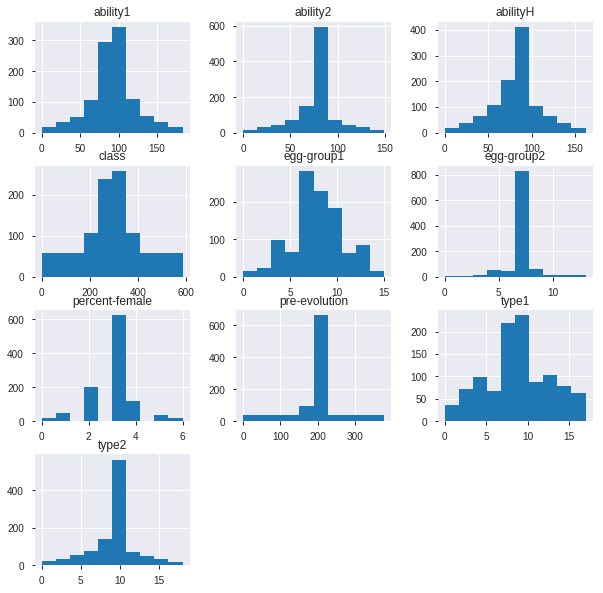

In [20]:
Real[object_name].hist(figsize=(10,10))
plt.show()

In [21]:
# total_length = 0 
# info = {}
# for i in object_name :
#     value = Real[i].nunique()
#     info[i] = value
#     total_length += value
    
# total_length += len(numeric_name)

# print(info)
total_length = np.shape(Real)[1]
print(total_length)

18


In [22]:
data = Real.values
def sample_data(n= len(data) , data = None) : 
    output = data[list(np.random.choice(len(data) , n))]
    return output

In [23]:
input_dim = np.shape(data)[1] 
latent_dim = 15

tf.reset_default_graph()
batch_size = tf.placeholder(tf.int64, name="Batchsize")
X = tf.placeholder(tf.float32,[None , total_length  ], name= "X")
Z = tf.placeholder(tf.float32,[None, latent_dim ] , name = "Z")
phase = tf.placeholder(tf.bool, name='phase')


def parametric_relu(_x):
    """
    maximum을 제한을 4정도로 줌 
    """
    alphas = tf.get_variable('alpha', _x.get_shape()[-1],
                       initializer=tf.constant_initializer(0.0),
                        dtype=tf.float32)
    pos = tf.minimum(tf.nn.relu(_x) , 4.0)
    neg = alphas * (_x - abs(_x)) * 0.5
    return pos + neg

def dense(x, size, scope):
    return tf.contrib.layers.fully_connected(x, size, 
                                             activation_fn=None,
                                             scope=scope)

def dense_batch_relu(input_ , output_ , activation , phase, scope):
    with tf.variable_scope(scope):
        h1 = tf.contrib.layers.fully_connected(input_ , output_ , 
                                               activation_fn=None,
                                               scope='dense')
        h2 = tf.contrib.layers.batch_norm(h1, 
                                          center=True, scale=True, 
                                          is_training=phase,
                                          scope='bn')
        if activation :
            output = activation(h2)
        else :
            output =h2
        return output
# 출처: https://creamyforest.tistory.com/48 [Dohyun's Blog]
def Relu2(tensor):
    return tf.minimum(tf.maximum(tensor,0.0) , 2.0)


def nalu_v2(input_layer, num_outputs):
    """ Neural Arithmetic Logic Unit tesnorflow layer
    Arguments:
    input_layer - A Tensor representing previous layer
    num_outputs - number of ouput units 
    Returns:
    A tensor representing the output of NALU
    """

    shape = (int(input_layer.shape[-1]), num_outputs)

    # define variables
    W_hat = tf.Variable(tf.truncated_normal(shape, stddev=0.02))
    M_hat = tf.Variable(tf.truncated_normal(shape, stddev=0.02))
    G = tf.Variable(tf.truncated_normal(shape, stddev=0.02))

    # operations according to paper
    W = tf.tanh(W_hat) * tf.sigmoid(M_hat)
    m = tf.exp(tf.matmul(tf.log(tf.abs(input_layer) + 1e-7), W))
    g = tf.sigmoid(tf.matmul(input_layer, G))
    a = tf.matmul(input_layer, W)
    out = g * a + (1 - g) * m

    return out


def highway(x, size, activation, carry_bias=-1.0):
    W_T = tf.Variable(tf.truncated_normal([size, size], stddev=0.1), name="weight_transform")
    b_T = tf.Variable(tf.constant(carry_bias, shape=[size]), name="bias_transform")
    W = tf.Variable(tf.truncated_normal([size, size], stddev=0.1), name="weight")
    b = tf.Variable(tf.constant(0.1, shape=[size]), name="bias")
    T = tf.sigmoid(tf.matmul(x, W_T) + b_T, name="transform_gate")
    H = activation(tf.matmul(x, W) + b) # , name="activation"
    C = tf.subtract(1.0, T, name="carry_gate")
    y = tf.add(tf.multiply(H, T), tf.multiply(x, C), "y")
    return y

def Encoder(X ,  is_training = True , reuse = False  , hsize = [50 , 40 , 30 , 20 , latent_dim ]) :
    with tf.variable_scope("BiGAN/Encoder",reuse=reuse): 
        h = layer(X , X.shape[1] , hsize[0] , "layer1" , belu , 
                   usebias = True ,  final = False , SN = False ,  Type = "Batch_Normalization" , phase = is_training
                  )
        h = layer(h , h.shape[1] , hsize[1] , "layer2" , belu , 
                   usebias = True ,  final = False , SN = True ,  Type = "Batch_Normalization" , phase = is_training
                  )
        h = layer(h , h.shape[1] , hsize[2] , "layer3" , belu , 
                   usebias = True ,  final = False , SN = True ,  Type = "Batch_Normalization" , phase = is_training
                  )
        h = layer(h , h.shape[1] , hsize[3] , "layer4" , belu , 
                   usebias = True ,  final = False , SN = False ,  Type = "Batch_Normalization" , phase = is_training
                  )
        tf.summary.histogram("ENC_Layer_1", h )
        out = tf.layers.dense(h, hsize[4], activation=None, use_bias=False )
        tf.summary.histogram("ENC_Layer", out)
        return out
        
        

def generator(Z , batch_size , hsize=[ 15, 20 , 25 , 30 ],reuse=False):
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        h1 = tf.layers.dense(Z   , hsize[0] , activation = belu , use_bias= True )
        #h1 = dense_batch_relu(h1 , 200 , belu , phase, "trans")
        tf.summary.histogram("G_Transform_z", h1)
        print(h1)
        h2 = layer(h1 , h1.shape[1] , hsize[1] , "layer1" , brelu , True , False ,
                   SN = True ,  Type = "Batch_Normalization" , phase = phase )
        tf.summary.histogram("G_Layer1", h2)
        print(h2)
        #h2 = dense_batch_relu(h1  ,hsize[1],  Relu2 , phase ,'layer1')
#         h2 = layer(h1 , h1.shape[1] , hsize[1] , "layer2" , belu , True , False , SN = False ,  Type = "Batch_Normalization" ,phase = phase)
#         tf.summary.histogram("G_Layer2", h2)
        #h3 = dense_batch_relu(h2  ,hsize[2],  belu , phase ,'layer2')
        h4 = layer(h2 , h2.shape[1] , hsize[2] , "layer3" , brelu , True , False ,
                   SN = True ,  Type = "Batch_Normalization" ,phase = phase )
        tf.summary.histogram("G_Layer3", h4)
#         h4 = layer(h3 , h3.shape[1] , hsize[3] , name =  "layer4" , activation = belu  ,
#                    usebias = True ,  final = False , SN = False ,  Type = "Batch_Normalization" , phase = phase)
#         tf.summary.histogram("G_Layer4", h4)
#       
        #h5 = dense_batch_relu(h4  ,hsize[4],  belu , phase ,'layer4')
        h5 = layer(h4 , h4.shape[1] , hsize[3] , "layer5" , belu , 
                   usebias = False ,  final = False , SN = True ,  Type = "Batch_Normalization" , phase = phase
                  )
        print(h5)
        tf.summary.histogram("G_Layer5", h5)
#         out = nalu_v2(h5 ,total_length )
#         print(out)
        out = tf.layers.dense(h5,  total_length , activation = None , use_bias= False )
        out = highway(out , total_length  , belu)
        out = tf.layers.dense(h5,  total_length , activation = None , use_bias= False )
        num = tf.get_variable('numeric',[ len(numeric_name) ] ,
                         initializer=tf.constant_initializer(0.0),
                         dtype=tf.float32)
        cat = tf.constant([0.0] , shape = [total_length - len(numeric_name)] , dtype = tf.float32)
        final_bias = tf.concat([num,cat],axis =0)
        #out = tf.layers.dense(out,  total_length, activation = None , use_bias= True )
        #out = nalu(out , total_length , epsilon=1e-7, name="nalu_total", reuse=reuse)
        first = tf.nn.tanh(out + final_bias) # tf_sqnl
        for v , col in enumerate(feature)  :
            value = tf.slice(out , [0, v ] , [batch_size , 1 ] ) # 
            tf.summary.histogram("Input_" + col , value )
        
#         num = tf.slice(out , [0,0] , [batch_size,  len(numeric_name) ] )  # 
#         for v , col in enumerate(feature[:len(numeric_name)])  :
#             value = tf.slice(num , [0, v ] , [batch_size , 1 ] ) # 
#             tf.summary.histogram("Input_" + col , value )
        
#         first = tf_sqnl(num)
#         cat = tf.slice(out , [0, len(numeric_name) ] , [batch_size , -1 ] )
#         shape = total_length - len(numeric_name)
#         W1 = tf.get_variable("Cat_Weight" , shape = [shape , shape] , 
#                              dtype = tf.float32 , initializer = tf.keras.initializers.he_uniform(seed = 1234))
#         cat2 = tf.matmul( cat  , W1 )
#         cat2 = tf.contrib.layers.batch_norm(cat2 , 
#                                             center=True, scale=True, 
#                                             is_training=phase , 
#                                             scope='bn')
#         cat2 = Relu2(cat2)
#         cat2 = tf.layers.dense(cat2 , shape , activation=None, use_bias=False )
#         for v , col in enumerate(feature[len(numeric_name):])  :
#             value = tf.slice(cat2 , [0, v + len(numeric_name) ] , [batch_size , 1 ] ) # 
#             tf.summary.histogram("Input_" + col , value )
#         cat2 = tf_sqnl(cat2)
#         first = tf.concat([first , cat2 ], axis = 1 , name = "Final" )
        
        
#         num = tf.slice(out , [0,0] , [batch_size,  len(numeric_name) ] )  # 
#         first = dense_batch_relu(num , len(numeric_name) , tf_sqnl , phase = phase, scope = "numlayer")
#         tf.summary.histogram("G_num", first )
#         cat = tf.slice(out , [0, len(numeric_name) ] , [batch_size , -1 ] )
#         shape1 = total_length - len(numeric_name)
#         shape2 = total_length - len(numeric_name)
#         W1 = tf.get_variable("Cat_Weight" , shape = [shape1 , shape2] , 
#                              dtype = tf.float32 , initializer = tf.keras.initializers.he_uniform(seed = 1234))
#         b1 = tf.get_variable("Cat_Bias" , shape = [shape2] , 
#                              dtype = tf.float32 , initializer = tf.constant_initializer(0.0))
#         cat2 = tf.matmul( cat  , W1 ) + b1
#         cat2 = tf.contrib.layers.batch_norm(cat2 , 
#                                            center=True, scale=True, 
#                                           is_training=phase,
#                                           scope='bn')
#         cat2 = tf_sqnl(cat2)
# #         cat2 = layer(cat , total_length - len(numeric_name) , total_length - len(numeric_name) , "catlayer" , tf_sqnl  , 
# #                      usebias = True ,  final = False , SN = False ,  Type = "Batch_Normalization" , phase = phase)
#         tf.summary.histogram("G_cat", cat2 )
         
    return first


def discriminator(X, latent_code , hsize=[60 , 50 , 40 , 30, 20],reuse=True):
    with tf.variable_scope("BiGAN/Discriminator",reuse=reuse):
        latent_fc = layer(latent_code  , latent_code.shape[1] , X.shape[1], name =  "latent_layer1" , activation = tf.nn.leaky_relu ,
                          usebias = True ,  final = False , SN = False ,  Type = "Batch_Normalization" , phase = phase)
        X = tf.concat([X , latent_fc] , axis = 1)
        h1 = layer(X  , X.shape[1] , hsize[0] , name =  "D_layer1" , activation = tf.nn.leaky_relu ,
               usebias = True ,  final = False , SN = True ,  Type = "Batch_Normalization" , phase = phase)
        h2 = layer(h1  , h1.shape[1] , hsize[1] , name =  "D_layer2" , activation = parametric_relu ,
               usebias = True ,  final = False , SN = True ,  Type = "Batch_Normalization" , phase = phase)
        #h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu , name = "D2" )
        #h2 = minibatch(h2 , name = "D2")
#         h2 = layer(h2  , h2.shape[1] , hsize[2] , name =  "D_layer3" , activation =  tf.nn.leaky_relu ,
#                usebias = True ,  final = False , SN = True ,  Type = "Batch_Normalization" , phase = phase)
        #h2 = tf.layers.dense(h2,hsize[2],activation=tf.nn.leaky_relu , name = "D3" )
        #h2 = minibatch(h2 , name = "D3")
        h2 = layer(h2  , h2.shape[1] , hsize[3] , name =  "D_layer4" , activation = tf.nn.leaky_relu ,
               usebias = True ,  final = False , SN = True ,  Type = "Batch_Normalization" , phase = phase)
#         h2 = minibatch(h2 , name = "D4")
        h3 = layer(h2  , h2.shape[1] , hsize[4] , name =  "D_layer5" , activation = parametric_relu ,
               usebias = True ,  final = False , SN = True ,  Type = "Batch_Normalization" , phase = phase)        
#         h3 = layer(h2  , h2.shape[1] , 100 , name =  "D_layer6" , activation = tf.nn.leaky_relu ,
#                usebias = True ,  final = False , SN = True ,  Type = "Batch_Normalization" , phase = phase)
        h3 = minibatch(h3 , num_kernels = 10 ,  bs = BATCH_SIZE ,name = "Minibatch_Discrimination")
        #h3 = tf.layers.dense(h2,10 ,activation=tf.nn.leaky_relu , name = "D4" )
        #h3 = minibatch(h3 , name = "D3")
        out = tf.layers.dense(h3,1) # activation=None OUTPUT
    return out, h3

def sample_Z(m , n ):
    #Uniform = np.random.uniform(-1., 1., size=[m , n])
    Normal = np.random.normal(loc = 0. ,  scale = 1. , size=[m , n])
    return Normal


In [ ]:
input_dim

18

In [ ]:
EPOCHS = 500000
BATCH_SIZE = 150
data_len = np.shape(data)[0]
batch_iter = int(data_len / BATCH_SIZE)

dataset = tf.data.Dataset.from_tensor_slices((X, Z)).batch(batch_size , drop_remainder=True ).repeat().shuffle(1000)
iter = dataset.make_initializable_iterator()
x , z = iter.get_next()

print(batch_iter)

Instructions for updating:
Colocations handled automatically by placer.
7


In [ ]:
G_sample = generator(z , batch_size)
latent = Encoder(x , reuse = False)
r_logits, r_rep = discriminator(x, latent , reuse=False)
f_logits, g_rep = discriminator(G_sample, z , reuse=True)
## 
#Recon_latent = Encoder(x , is_training=False , reuse = True)
G_sample_DATA = G_sample
#generator(z , batch_size , reuse = True )

# e = tf.random_uniform([BATCH_SIZE , 1] , 0 , 1)
# x_hat =  e * x + (1-e) * G_sample
# grad  = tf.gradients( discriminator(x_hat,reuse=True ), x_hat)[0]

#grad_norm = tf.norm( tf.layers.flatten(grad) , axis = 1)
#LP = 10 * tf.reduce_mean( tf.square( tf.maximum(0.0 ,grad_norm - 1.0)))


# slopes = tf.sqrt(1e-8 + tf.reduce_sum(tf.square(grad), axis=[1]))
# gradient_penalty = 5 * tf.reduce_mean((slopes - 1.) ** 2)

Instructions for updating:
Use keras.layers.dense instead.
Tensor("GAN/Generator/dense/Reshape_1:0", shape=(?, 15), dtype=float32)
Tensor("GAN/Generator/layer1/Reshape_3:0", shape=(?, 20), dtype=float32)
Tensor("GAN/Generator/layer5/Reshape_3:0", shape=(?, 30), dtype=float32)
INFO:tensorflow:Summary name Input_weight(kg) is illegal; using Input_weight_kg_ instead.
INFO:tensorflow:Summary name Input_height(cm) is illegal; using Input_height_cm_ instead.


In [ ]:
def moment(x = None , nth = 3) :
    """Column 별 3차 모멘트 계산"""
    std = tf.math.reduce_std(x , axis = 0) 
    std = tf.clip_by_value(std , 0.001 , 20.0 ) 
    standard = tf.div(x - tf.reduce_mean(x, axis = 0) ,  std ) + 1e-10
    pow_3 = tf.pow(standard ,nth )
    three_moment = tf.reduce_mean(pow_3 , axis = 0)
    return three_moment

In [ ]:
# fake_logit = (f_logits - tf.reduce_mean(r_logits))
# real_logit = (r_logits - tf.reduce_mean(f_logits))
# real_logit = tf.sigmoid( real_logit )
# fake_logit = tf.sigmoid( fake_logit )
# disc_loss = - tf.reduce_mean( log(real_logit)) - tf.reduce_mean( log(1-fake_logit ))
# gen_loss = - tf.reduce_mean( log( fake_logit )) - tf.reduce_mean( log(1- real_logit ))


# disc_loss = tf.reduce_mean(
#     tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) + 
#     tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)) , name = "discriminator_loss")
# gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)), name= "generator_loss")

## wgan Loss 변경
### 이유 : 이전에는 이미지다보니 2D 전체를 하는 것이 맞지만, 테이블 데이터 같은 경우에는 열별로 비교해야할듯하다.
### 이유2 : 전체적인 것도 고려할 수 있게하기! 
e = tf.random_uniform([BATCH_SIZE , 1] , 0 , 1)
x_hat =  e * x + (1-e) * G_sample
latent_x_hat =  e * z + (1-e) * latent
grad  = tf.gradients( discriminator(x_hat, latent_x_hat , reuse=True ), x_hat)[0]
slopes = tf.sqrt(1e-8 + tf.reduce_sum(tf.square(grad), axis=[1]))
gradient_penalty = 5 * tf.reduce_mean((slopes - 1.) ** 2)

fake_logit = (f_logits - tf.reduce_mean(r_logits))
real_logit = (r_logits - tf.reduce_mean(f_logits))
real_logit = tf.sigmoid( real_logit )
fake_logit = tf.sigmoid( fake_logit )

with tf.variable_scope("Discriminator_Loss") :        
#     total_disc_loss = tf.reduce_mean(f_logits) - tf.reduce_mean(r_logits)     
#     col_disc_loss = tf.reduce_sum(tf.reduce_mean(f_logits , axis = 0 ) - tf.reduce_mean(r_logits , axis = 0  ))
#     ratio = 1.0
#     disc_loss = ratio * total_disc_loss + (1-ratio) * col_disc_loss 
    disc_loss = - tf.reduce_mean( log(real_logit)) - tf.reduce_mean( log(1-fake_logit ))
    disc_loss += gradient_penalty

## 기존 wgan loss
#disc_loss = tf.reduce_mean(f_logits  ) - tf.reduce_mean(r_logits  ) + gradient_penalty
#gen_loss  = - tf.reduce_mean(f_logits)


## Numeric 변수에 대한 Correlation Loss 추가
### 이유는 상관관계가 유사하게 나와야 하기 때문에 규제를 주는 역할을 기대할 수 있다!
### Generator Loss에 넣어서 Generator에서만 Weight 조절할수 있게! 
def tf_cov(x):
    mean_x = tf.reduce_mean(x, axis=0, keep_dims=True)
    mx = tf.matmul(tf.transpose(mean_x), mean_x)
    vx = tf.matmul(tf.transpose(x), x)/tf.cast(tf.shape(x)[0], tf.float32)
    cov_xx = vx - mx
    return cov_xx
def kl_divergence_gaussians(q_mu, q_sigma, p_mu, p_sigma) :
    r = q_mu - p_mu
    return tf.reduce_sum( log(p_sigma) - log(q_sigma) - .5 * (1. - (q_sigma**2 + r**2) / p_sigma**2), axis=-1)

def Differ_Round(x) :
    ## https://stackoverflow.com/questions/46596636/differentiable-round-function-in-tensorflow
    differentiable_round = tf.maximum(x-0.499,0)
    differentiable_round = differentiable_round * 10000
    differentiable_round = tf.minimum(differentiable_round, 1) + 1e-20
    return differentiable_round

with tf.variable_scope("Generator_Loss"):
    with tf.variable_scope("Original_Loss"):
        gen_loss = - tf.reduce_mean( log( fake_logit )) - tf.reduce_mean( log(1- real_logit ))
        #gen_loss  = - tf.reduce_mean(f_logits)
        # -tf.reduce_sum(tf.reduce_mean(f_logits , axis = 0 ))
    with tf.variable_scope("Corr_Loss"):
        num_G = tf.slice(G_sample , [0,0] , [batch_size,  len(numeric_name) ] )  # 
        num_R = tf.slice(x , [0,0] , [batch_size,  len(numeric_name) ] )  # 
        matrix = tf_cov(num_G) - tf_cov(num_R)
        Upper_triangular = tf.matrix_band_part(matrix, 0, -1)
        corr_loss = tf.reduce_sum(tf.square( Upper_triangular ))        
    tf.summary.scalar("Corr_loss", corr_loss)
    #gen_loss += 1 * corr_loss
    with tf.variable_scope("wasserstein_Loss"):
#         num_G = tf.slice(G_sample , [0,0] , [batch_size,  len(numeric_name) ] )  # 
#         cat_G = tf.slice(G_sample , [0, len(numeric_name)] , [batch_size,  -1 ] )  # 
#         Round_G = Differ_Round(cat_G)
#         Processing_G = tf.concat([num_G , Round_G] , axis = 1 )
#         wasserstein = Wasserstein(Processing_G  , x , BATCH_SIZE)
        wasserstein = Wasserstein(G_sample  , x , BATCH_SIZE)
        loss = wasserstein.dist(C=0.1, nsteps=50)
    tf.summary.scalar("wasserstein_loss", loss)
    gen_loss += loss
    with tf.variable_scope("Stat"):
        Gcol_mean , Gcol_var = tf.nn.moments(G_sample , axes = [0])
        Xcol_mean , Xcol_var = tf.nn.moments(x , axes = [0])
        G_mean , G_var = tf.nn.moments(G_sample , axes = [0,1])
        X_mean , X_var = tf.nn.moments(x , axes = [0,1])
        Colstat = tf.reduce_mean(tf.square(Gcol_mean - Xcol_mean)) \
        + tf.reduce_mean(tf.square( tf.sqrt(Gcol_var + 1e-10) - tf.sqrt(Xcol_var + 1e-10 )))
        Totalstat = tf.reduce_mean(tf.square(G_mean - X_mean)) \
        + tf.reduce_mean(tf.square( tf.sqrt(G_var + 1e-10 ) - tf.sqrt(X_var + 1e-10 )))
        ## 추가 빈도 비율이 유사하게 되지 않을까!?
    with tf.variable_scope("Categorical_Ratio"):
        cat_G = tf.slice(G_sample , [0, len(numeric_name)] , [batch_size,  -1 ] )  # 
        cat_R = tf.slice(x , [0,  len(numeric_name)] , [batch_size,  -1] )  # 
#         Round_G = tf.reduce_sum(Differ_Round(cat_G) , axis = 0 )
#         Round_R = tf.reduce_sum(Differ_Round(cat_R) , axis = 0 )
        Round_G = tf.reduce_sum(cat_G + 1.000001 , axis = 0 )
        Round_R = tf.reduce_sum(cat_R + 1.000001 , axis = 0 )
        D = tf.shape(cat_R)[1]
        q_sigma = tf.ones(D) * 1.0
        p_sigma = tf.ones(D) * 1.0
        ## 너무 Loss가 폭발해서 sum -> mean으로 수정 
        KL_LOSS = tf.reduce_sum(tf.distributions.kl_divergence(
            tf.distributions.Normal(loc=Round_G, scale=q_sigma),
            tf.distributions.Normal(loc=Round_R, scale=p_sigma)), axis=-1) * 0.5 
        
        """
        제한은 주지만, 너무 Loss가 크게 의존하지는 않게,
        """
        Cat_Ratio = tf.reduce_mean( tf.square(Round_G - Round_R) ) * 0.5
        normalize_a = tf.nn.l2_normalize(Round_G,0)        
        normalize_b = tf.nn.l2_normalize(Round_R,0)
        cos_similarity=tf.reduce_sum(tf.multiply(normalize_a,normalize_b))
        Similarity_Loss = 1 * cos_similarity
    tf.summary.scalar("Categorical_Ratio_loss", Cat_Ratio)
    tf.summary.scalar("Colstat_loss", Colstat)
    tf.summary.scalar("Totalstat_loss", Totalstat)
    tf.summary.scalar("Similarity_loss", Similarity_Loss)
    tf.summary.scalar("Categorical_KL_loss", KL_LOSS)
    #gen_loss +=  Totalstat + Cat_Ratio + Similarity_Loss + KL_LOSS 
    gen_loss += KL_LOSS
    with tf.variable_scope("Moment"):
        num_G = tf.slice(G_sample , [0,0] , [batch_size,  len(numeric_name) ] )  # 
        num_R = tf.slice(x , [0,0] , [batch_size,  len(numeric_name) ] )  # 
        Diff_3 = moment(num_G,3) - moment(num_R,3)
        three_moment_diff = tf.reduce_sum(tf.square(Diff_3)) * 0.1
        Diff_4 = moment(num_G,4) - moment(num_R,4)
        ## 너무 강하게 자극을 받는 듯 수정 필요 
        #four_moment_diff = tf.reduce_sum(tf.square(Diff_4))
        four_moment_diff = tf.reduce_mean(tf.square(Diff_4)) * 0.1
    tf.summary.scalar("3th_moment", three_moment_diff)
    tf.summary.scalar("4th_moment", four_moment_diff)
    gen_loss += three_moment_diff + four_moment_diff
    # Colstat +


## BATCH NORMALIZATION LOSS 
from tensorflow.python.ops import control_flow_ops
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
if update_ops != [] : 
    updates = tf.group(*update_ops)
    gen_loss = control_flow_ops.with_dependencies([updates], gen_loss)

with tf.variable_scope("Loss"):
    tf.summary.scalar("Dloss", disc_loss)
    tf.summary.scalar("Gloss", gen_loss)

t_vars = tf.trainable_variables()

for var in t_vars :
    tf.summary.histogram(var.op.name, var)

global_step = tf.get_variable('global_step', [], initializer=tf.constant_initializer(0), trainable=False)
gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator") + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='BiGAN/Encoder')
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="BiGAN/Discriminator")

# learning_rate = tf.train.exponential_decay(lr, global_step, decay_steps=100, decay_rate=0.9998, staircase=True , )
lr = 0.0001
learning_rate = tf.train.cosine_decay_restarts(lr , global_step, first_decay_steps= 100  , 
                                               t_mul=1.0, m_mul=0.994, alpha=0.5)

tf.summary.scalar("learning_rate", learning_rate)
with tf.variable_scope("Optimizer"):
    gen_step = tf.train.AdamOptimizer(learning_rate=learning_rate ,
                                      beta1=0.9, beta2 = 0.99 ).minimize(gen_loss,var_list = gen_vars) # G Train step
    disc_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(disc_loss,var_list = disc_vars) # D Train step
    

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [ ]:
#tensorboard()

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
config=tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
merged_summary = tf.summary.merge_all()
sess = tf.Session(config= config)
saver = tf.train.Saver()

naming = 'Gan_Pokemon_new_V_bigan_7'
suumary_dir = "/home/advice/Python/SR/board/" + naming
img_dir = "./" + naming
try :
    if tf.gfile.Exists(suumary_dir):
        tf.gfile.DeleteRecursively(suumary_dir)
        tf.gfile.MakeDirs(suumary_dir)
        tf.gfile.DeleteRecursively(img_dir)
        tf.gfile.MakeDirs(img_dir)
except Exception as e :
    tf.gfile.MakeDirs(img_dir)
tf.gfile.MakeDirs(img_dir)
    
writer = tf.summary.FileWriter(suumary_dir)
writer.add_graph(sess.graph )
tf.global_variables_initializer().run(session=sess)

In [ ]:
load_model = False
if load_model == True :
    print("학습된 모델 사용하기")
    save_file = "./savemodel/gan.meta"
    saver = tf.train.import_meta_graph(save_file)
    saver.restore(sess, tf.train.latest_checkpoint('./savemodel/'))
else :
    print("처음부터 학습시키기")

처음부터 학습시키기


## DATA Preprocessing

(array([ 19.,  33.,  52., 106., 294., 343., 108.,  53.,  34.,  19.]),
 array([  0. ,  18.3,  36.6,  54.9,  73.2,  91.5, 109.8, 128.1, 146.4,
        164.7, 183. ]),
 <a list of 10 Patch objects>)

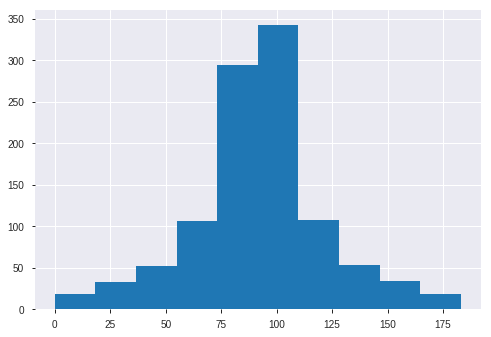

In [ ]:
plt.hist(data[:,10])

In [ ]:
original = data.copy()
transform = original.copy()

In [ ]:
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder()
onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
##
# TOTAL = data[:,:len(numeric_name)]
# onehot_bin = []
# value2code = {}
# code2value = {}
# for i in range(len(numeric_name) , np.shape(data)[1]) :
#     print(feature[i])
#     label_encoder.fit(data[:,i])
#     keys = label_encoder.classes_.tolist()
#     value2code[feature[i]] = dict(zip(keys , np.arange(len(keys))))
#     code2value[feature[i]] = dict(zip(np.arange(len(keys)), keys))
#     encoding = label_encoder.transform(data[:,i])
#     onehot_encoder.fit(np.array(encoding).reshape(-1,1))
#     cat = onehot_encoder.transform(np.array(encoding).reshape(-1,1))
#     onehot_bin.append(TOTAL.shape[1])
#     before = TOTAL.shape[1]
#     TOTAL = np.concatenate((TOTAL , cat) , axis = 1 )
#     print("{} 위치[{}] : {}:{}".format(feature[i], i , before  , TOTAL.shape[1] +1 ))
#     transform[:,i] = label_encoder.transform(transform[:,i])

In [ ]:
# data = TOTAL
# del TOTAL
# onehot_bin += [data.shape[1]]
# print(onehot_bin)
# np.bincount(np.argmax(data[:,995:1002] , axis = 1)).sum()

In [ ]:
x_plot = sample_data(n= 1000 , data = transform ).astype(float) # len(data)
x_plot.shape

(1000, 18)

In [ ]:
# x_plot2 = x_plot[:,:len(numeric_name)].copy()
# for idx , i in enumerate(onehot_bin[:-1]) :
#     x_plot2 = np.concatenate( (x_plot2 ,
#                                np.argmax(x_plot[:, onehot_bin[idx] : onehot_bin[idx+1] ] , 1 )[:,np.newaxis] ) , axis = 1 )
# x_plot = x_plot2
# del x_plot2

In [ ]:
print("Numeric NAME : {}".format(numeric_name))

Numeric NAME : ['hp', 'attack', 'defense', 'spattack', 'spdefense', 'speed', 'weight(kg)', 'height(cm)']


In [ ]:
from scipy.stats import wasserstein_distance as was_dist
nd_steps = 1
ng_steps = 1
save_model = True
scaler = MinMaxScaler(feature_range=(-1. ,1.))
## 표준화로 해보기!
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#data[:,:len(numeric_name)] = scaler.fit_transform(data[:,:len(numeric_name)])



data = scaler.fit_transform(data)

(array([ 19.,  36.,  63., 106., 205., 411., 103.,  63.,  36.,  19.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

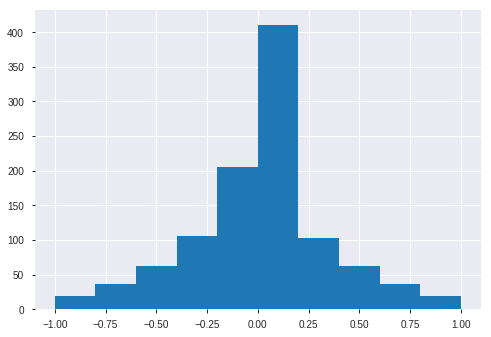

In [ ]:
plt.hist(data[:,12])

In [ ]:
max_idx = data[: , len(numeric_name) : ] == 1.0
min_idx = data[: , len(numeric_name) : ] == -1.0
interval_idx = ~max_idx & ~min_idx

In [ ]:
Onehot_shape = data[: , len(numeric_name) : ].shape
#true_idx = data[: , len(numeric_name) : ] > 0 
#random_init = np.random.uniform(low = 0.0001 , high = 0.001 , size = Onehot_shape)
random_init = np.random.normal(loc = 0.0 , scale = 0.001 , size = Onehot_shape)
data[: , len(numeric_name) : ] = data[: , len(numeric_name) : ] * max_idx + data[: , len(numeric_name) : ] * min_idx +   (data[: , len(numeric_name) : ] + random_init) * interval_idx 

In [ ]:
np.max(data[: , len(numeric_name) : ], axis = 0)
np.min(data[: , len(numeric_name) : ], axis = 0)

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

(array([ 19.,  36.,  63., 106., 307., 309., 103.,  63.,  36.,  19.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

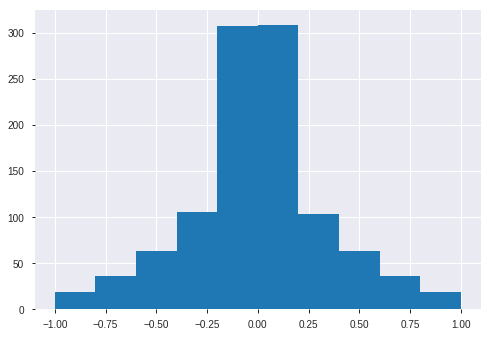

In [ ]:
## epsilon 추가
plt.hist(data[:,12])


In [ ]:
x_plot.shape

(1000, 18)

## Visualization 함수

In [ ]:
def Gan_Vis(g_plot , x_plot , total_dist , i , dloss ,gloss  ) : 
    clear_output(wait= True)
    fig, ax = plt.subplots(4,5, figsize=(18, 12))
    fig.subplots_adjust(hspace = 0.35 , wspace= 0.14 , top = 0.92 , left = 0.03 , bottom = 0.04 , right = 0.99)
    axx = ax.flatten()
    num = 0

    ## total 변수 
    total_var = 0
    g_total_var = 0
    
    for n , name in enumerate(feature) :
    
        """
        bin count 비교
        """
        if name in object_name  :
            print(name)
            print("gene -----------")
            print(np.bincount( np.array(g_plot[:,n]).astype(int) ) )
            print("true -----------")
            print(np.bincount( np.array(x_plot[:,n]).astype(int) ) )
            print("-----------------")
        """
        Visualization
        """
        ## object 
        if name in object_name  :
            binsize = len(np.unique(x_plot[:,n].astype(float) ))
#             if name == "percent-female" :
#                 Real_MALE = [code2value[name][letter] for letter in x_plot[:,n].astype(float) ]
#                 Gene_MALE = [code2value[name][letter] for letter in g_plot[:,n].astype(float) ]
            sns.distplot(x_plot[:,n].astype(float) , kde = False ,  
                         hist_kws ={"color":"r", "label" : "Real"} ,  
                         bins = binsize ,
                         rug = False , ax = axx[num])
            sns.distplot(g_plot[:,n],  kde = False ,  
                         hist_kws ={"color":"g" , "label" : "Gene"} ,
                         bins = binsize , 
                         rug = False   , ax = axx[num])
        ## numeric
        else :
            ## numeric_int
            if name in Int_name  : 
                Real  = x_plot[:,n].astype(float).round(0)
                Fake  = g_plot[:,n].round(0)
                binsize= len(np.unique(Real))
                if name in ['hp', 'attack', 'defense', 'spattack', 'spdefense', 'speed'] :
                    total_var += Real
                    g_total_var += Fake
                sns.distplot(Real  , kde_kws ={"color": "r", "label" : "Real"} , bins = binsize , rug= False , 
                             hist_kws ={"color":"r"}, ax = axx[num])
                sns.distplot(Fake , kde_kws ={"color": "g", "label" : "Gene"} , bins = binsize , rug= False , 
                             hist_kws ={"color":"g"}, ax = axx[num])
            ## numeric_float
            elif name in float_name :
                Real  = x_plot[:,n].astype(float)
                Fake  = g_plot[:,n]
                ## 사후 전처리 
                sns.distplot(Real  , kde_kws ={"color": "r", "label" : "Real"} , hist_kws ={"color":"r"}, ax = axx[num])
                sns.distplot(Fake , kde_kws ={"color": "g", "label" : "Gene"} , hist_kws ={"color":"g"}, ax = axx[num])
        
        axx[num].set_title("{}".format(name))
        num +=1
    for name_2 in ["total"] :
        if name_2 == "total" :
            sns.distplot(total_var  , kde_kws ={"color": "r", "label" : "Real"} , hist_kws ={"color":"r"}, ax = axx[num])
            sns.distplot(g_total_var , kde_kws ={"color": "g", "label" : "Gene"} , hist_kws ={"color":"g"}, ax = axx[num])
#         elif name_2 == "percent-male" :
#             Real_ = [replace_gender[letter] for letter in Real_MALE ]
#             Gene_ = [replace_gender[letter] for letter in Gene_MALE ]
            
            
#             Real_ = [ male if male == "NULL" else str(1-male.astype(float)) for male in Real_ ]
            
#             Gene_ = [ male if male == "NULL" else str(1-male.astype(float)) for male in Gene_ ]
#             print("Gene----")
#             print(collections.Counter(Gene_))
#             print("Real----")
#             print(collections.Counter(Real_))
#             label_encoder.fit(Real_)
#             R_Male = label_encoder.transform(Real_ )
#             G_Male = label_encoder.transform(Gene_ )
#             binsize = len(np.unique(R_Male.astype(float) ))
#             sns.distplot(R_Male.astype(float) , kde = False ,  
#                          hist_kws ={"color":"r", "label" : "Real"} ,  
#                          bins = binsize ,
#                          rug = True , ax = axx[num])
#             sns.distplot(G_Male ,  kde = False ,  
#                          hist_kws ={"color":"g" , "label" : "Gene"} ,
#                          bins = binsize , 
#                          rug = True   , ax = axx[num])
        axx[num].set_title("{}".format(name_2))
        num +=1
    
    plt.suptitle('Iteration %d , D_loss : %.4f , G_loss : %.4f , Dist : %.4f'%(i,dloss,gloss, total_dist) )
    
    img_dir_path = img_dir + '/iteration_%d.png'%i
    plt.savefig(img_dir_path)
    plt.close()
    return img_dir_path



def Iter_History(Total_ws = None , i = None ,save_dir = './Pokemon_Dist_v5.png' ) :    
    fig , ax = plt.subplots(figsize = (26,13))
    fig.subplots_adjust(top = 0.95 , left = 0.03 , bottom = 0.04 , right = 0.99)
    ax.plot(Total_ws["iter"] , Total_ws["ws"] , linestyle ="-" , marker ="." , linewidth = 3, markersize = 12)
    ax.plot(Total_ws["iter"] , Total_ws["ws"]-1.96*Total_ws["wstd"] , linestyle ="dashed"  , linewidth = 1)
    ax.plot(Total_ws["iter"] , Total_ws["ws"]+1.96*Total_ws["wstd"] , linestyle ="dashed"  , linewidth = 1)
    try :
        ax.set_title("EPOCH : {} , WS : {:.3f}[{:.3f}]".format(i , Total_ws["ws"].tail(1).values[0] , Total_ws.ws.min()) , fontsize = 30)
        ax.axhline(y = Total_ws["ws"].min() , color='r', linestyle='-')
        minws = Total_ws["ws"].min()
        miniter = Total_ws.loc[Total_ws["ws"] == minws , "iter"].values[0]
        print(miniter , minws )
        ax.text(Total_ws.iter.max()/2 , minws  , "EPOCH : {} , Min : {:.2f}".format(miniter  , minws ) , 
                fontsize=30, va='center', ha='center', backgroundcolor='w')
        plt.savefig(save_dir)
        plt.show()
    except Exception as e :
        print(e)
        pass
    
def Columns_Dist(ws_output , total_dist , Total_ws , save_dir , i ) : 
	fig , ax = plt.subplots(figsize=(26,13))
	fig.subplots_adjust(top = 0.95 , left = 0.03 , bottom = 0.05 , right = 0.99)
	updown = 0
	for name in feature : 
	    if updown % 2 == 0 :
	        param , space="bottom" , "  "
	    else : 
	        param , space ="top" , "   "
	    ax.plot(ws_output.iter , ws_output[[name]], label = name)
	    ax.text(i , ws_output.loc[ws_output["iter"]==i , [name]].values , space + name ,
	            verticalalignment = param)
	    updown +=1
	ax.set_title("WS [{}]".format(total_dist) , fontsize = 30 )
	ax.set_xlabel("Epoch")
	ax.set_ylabel("WS")    
	box = ax.get_position()
	ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
	ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=15 , fontsize= 10)
	ax.text(i + 1 , 0.05 , "   0.05", verticalalignment = param)
	ax.axhline(0.05, linewidth=4, color='r')
	ax.set_title("EPOCH : {} , WS : {:.2f}[{:.2f}]".format(i  , total_dist , Total_ws.ws.min()  ) , fontsize = 30)
	plt.savefig( save_dir )
	plt.close()

In [ ]:

from scipy import stats

def main() :
    imgs = []
    Total_ws = pd.DataFrame({"iter":[0] , "ws" :[0], "wstd" : [0]})
    ws_output = pd.DataFrame([[0]+[1.]*len(feature)], columns = ["iter"]+feature)
    for i in range(EPOCHS) : 
        z_batch = sample_Z(data_len , latent_dim )
        sess.run(iter.initializer, feed_dict={ X : data , 
                                              batch_size: BATCH_SIZE , 
                                              Z : z_batch  ,
                                              phase : 1
                                             })
        #for _ in range( batch_iter)  :
        nd_steps = 5
        for _ in range(nd_steps):
            _, dloss  = sess.run([disc_step, disc_loss] , feed_dict={global_step : i ,
                                                                     batch_size : BATCH_SIZE ,
                                                                     phase : 1
                                                                    })
        #writer.add_summary(summary, global_step=i)
        ng_steps = 2
        for _ in range(ng_steps):
            _, gloss = sess.run([gen_step, gen_loss], feed_dict={global_step : i , 
                                                                 batch_size : BATCH_SIZE ,
                                                                 phase : 1
                                                                })
        ### 채찍을 가하기
        if (i > 100)  and ( i % 20 == 0 ) : 
            setting = 300 if dloss < 20 else 400 if dloss > 50 else 500
            print("D : {:.2f} , G : {:.2f}".format(dloss , gloss))
            goal = 1.0 if dloss < 20 else dloss / 5
            iter_d = 0
            while dloss > goal :
                _, dloss  = sess.run([disc_step, disc_loss] , 
                                     feed_dict={global_step : i ,
                                                batch_size : BATCH_SIZE ,
                                                phase : 1
                                               })
                
                iter_d += 1
                ## 너무 과하게는 하지 않기 
                if iter_d > setting :
                    break
            
            iter_g = 0
            setting = 500 if gloss < 10 else 1000 if gloss > 20 else 750
            goal = 1.0 if gloss < 20 else gloss / 5
            while gloss > goal :
                _, gloss = sess.run([gen_step, gen_loss], 
                                    feed_dict={
                                        global_step : i , 
                                        batch_size : BATCH_SIZE ,
                                        phase : 1 
                                              })
                iter_g += 1
                ## 너무 과하게는 하지 않기 
                if iter_g > setting :
                    break
        
            print("After : D : {:.2f} , G : {:.2f}".format(dloss , gloss))    
        #writer.add_summary(summary, global_step = i)
        """
        Distance Measure
        """
        generate_n = 1000
        z_batch = sample_Z(generate_n  , latent_dim )
        ## 샘플개수만큼 여기서는 다 사용해서 x : data가 가능했음 
        g_plot = sess.run(G_sample_DATA , feed_dict = {x : data , z : z_batch , batch_size : generate_n , phase : 0})
        g_plot = scaler.inverse_transform(g_plot)
        g_numeric = g_plot
#         g_numeric = g_plot[:,:len(numeric_name)]
#         for idx , _ in enumerate(onehot_bin[:-1]) :
#             cat = np.argmax(g_plot[:, onehot_bin[idx] : onehot_bin[idx+1] ], 1 )
#             g_numeric = np.concatenate((g_numeric ,cat[:,np.newaxis] ) , axis = 1 )
        g_plot = g_numeric
        del g_numeric
        total_dist = 0 
        dist_set = []
        for n , name in enumerate(feature) :
            try :
                if n > len(numeric_name) -1 :
                    R = np.round(x_plot[:,n])
                    G = np.round(g_plot[:,n])
                    DIST = was_dist(R ,G) * 10
                else :
                    R = x_plot[:,n]
                    G = g_plot[:,n]
                    DIST = was_dist(R , G)
                total_dist += DIST
                dist_set.append(DIST)
            except Exception as e :
                print(e)
                total_dist += 1000
                dist_set.append( 1000 )
                
        ws_2 = [i] + dist_set
        ws_3 = pd.DataFrame([ws_2], columns = ["iter"] + feature )
        ws_output = ws_output.append(ws_3)
        Total_ws = Total_ws.dropna()
        print("Iter : {} , {} > {} ?!".format(i , Total_ws.ws.min() , total_dist))
        if i % 25 == 0 :
            clear_output(wait= True)
        if ( (Total_ws.ws.min() > total_dist) and (i> 100)  ) or ( (i % 500 == 0) and (i>0) ) or (i == 1 | 2) :
            try :
                _ , _ , summary_str = sess.run([disc_loss , gen_loss , merged_summary] , 
                                                       feed_dict = {global_step : i ,
                                                                    batch_size : BATCH_SIZE ,
                                                                    phase : 1
                                                                   })
                writer.add_summary(summary_str , global_step = i)
            except Exception as e :
                pass 

            if save_model == True :
                saver.save(sess, './savemodel/gan')
            clear_output(wait= True)
            imgs.append(Gan_Vis(g_plot, x_plot, total_dist , i , dloss ,gloss  ))
            ws_output = ws_output[ws_output.iter > 0 ]
            Columns_Dist(ws_output , total_dist , Total_ws , save_dir = './{}_ind.png'.format(naming) , i = i  )
            ## 쓸모없는 것 제거 
            total_dist = []
            for _ in range(10) :
                sampling = sample_data(n= generate_n , data = transform).astype(float) # len(data)
                dist = 0
                for col in range(len(feature)) :
#                     try :
#                         dist += was_dist(sampling[:,col], g_plot[:,col])
#                     except Exception as e :
#                         ## Penalty
#                         dist += 100
#                         pass
                    try :
                        if col > len(numeric_name) -1 :
                            R = np.round(sampling[:,col])
                            G = np.round( g_plot[:,col])
                            DIST = was_dist(R ,G) * 10
                        else :
                            R = sampling[:,col]
                            G = g_plot[:,col]
                            DIST = was_dist(R , G)
                        dist += DIST
                    except Exception as e :
                        DIST = 1000
                        dist += DIST
                        print(e)
                total_dist.append([dist])
                        
            total_std = np.std(total_dist)
            total_dist = np.mean(total_dist)
            iter_ws = pd.DataFrame({"iter":[i] , "ws" :[total_dist] , "wstd" : [total_std]})
            print(iter_ws)
            Total_ws    = Total_ws.append(iter_ws)
            Total_ws = Total_ws[Total_ws.iter > 0 ]
            Total_ws.to_csv("./{}.csv".format(naming) , index = False )
            Iter_History(Total_ws , i , save_dir = './{}.png'.format(naming) )
    return imgs 

In [ ]:
if __name__ == "__main__" :
    imgs = main()

Iter : 10151 , 993.531605355538 > 1111.0199346121476 ?!
Iter : 10152 , 993.531605355538 > 1099.9299266206838 ?!
Iter : 10153 , 993.531605355538 > 1103.3951578663946 ?!
Iter : 10154 , 993.531605355538 > 1114.064189582244 ?!
Iter : 10155 , 993.531605355538 > 1125.3529782667028 ?!
Iter : 10156 , 993.531605355538 > 1114.1510560699087 ?!
Iter : 10157 , 993.531605355538 > 1108.1804433121515 ?!
Iter : 10158 , 993.531605355538 > 1128.3063299040593 ?!
Iter : 10159 , 993.531605355538 > 1092.879078441498 ?!
D : 1.37 , G : 95.64


In [ ]:
imgs

In [ ]:
import os
img2gif = 'convert -delay 30 -loop 0 %s {}/simulation.gif'.format(img_dir)
os.system(img2gif % ' '.join(imgs))

In [ ]:
if (100 > 110 ) or (100 % 100 == 0) :
    print("Pass?")
else :
    print("Not Pass")